## Article implementation:
### ImageNet Classification with Deep Convolutional Neural Networks
#### Autors: Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

Importing the required libraries

In [3]:
# General libs
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
from pathlib import Path
from datetime import datetime

# Libs for plotting
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Fixing seed for reproducing results

In [4]:
SEED = 2020

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
MODES = ['train', 'val', 'test']
DEVICE = torch.device("cuda")

### Forming datasets

Create class for future augmentation in training datasets

In [6]:
class GaussianNoise():
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

For collecting images in union dataset from different folders (also folders have the classe names) create special class which will load the files from folders, transforms it and return dataset in pytorch Tensor type 

In [7]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in MODES:
            print(f"{self.mode} is not correct; correct modes: {MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.Resize(size=(227, 227)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=30),
                transforms.RandomApply([transforms.ColorJitter(hue=0.1, saturation=0.1)], p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                transforms.RandomApply([GaussianNoise(0, 0.25)], p=0.5)
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(227, 227)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

Creating list of file names

In [8]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Create train/test split on the list of file names

In [9]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

Our classes highly unbalanced. Let's find these calsses and sample their data to minimum 150 samples per class.

In [10]:
label_series = pd.Series(list(map(lambda x: x.parent.name, train_files)) )
label_comp = label_series.value_counts()[label_series.value_counts()<150]

to_dict = list(map(lambda x, y: [x.parent.name,y], train_files,train_files))

dict_map = dict()
for name, path in to_dict:
    if name in dict_map:
        dict_map[name].append(path)
    else:
        # create a new array in this slot
        dict_map[name] = [path]

for name, num in zip(label_comp.index, label_comp):
    source = dict_map[name]
    to_upsample = random.choices(source, k=150-num)
    train_files.extend(to_upsample)

Finally create datasets for our neural net

In [11]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
print('Datasets created!')

Datasets created!


Auxillary function for showing picture from pytorch tensors

In [12]:
def imshow(inp, title='Image from dataset'):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)

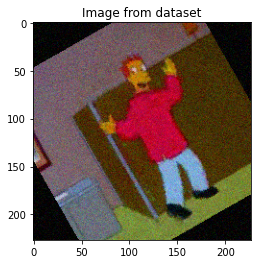

In [13]:
imshow(train_dataset.__getitem__(9000)[0])

### Defining architecture 

Define architecture from paper

In [14]:
class AlexNet(nn.Module):
    def __init__(self, input_dim = 3):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_dim, 96, kernel_size = 11, stride=4),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=10**(-4), beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
           
            
            nn.Conv2d(96, 256, kernel_size= 5, stride = 1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=10**(-4), beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), 

            
            nn.Conv2d(256, 384, kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            
            nn.Conv2d(384, 384, kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.linear = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 42)
        )

    def forward(self, batch):
        x = self.conv(batch)
        x = x.view(-1, 256*6*6)
        return self.linear(x)
    
    
    def save_model(self):
        torch.save(self.state_dict(), 'AlexNet_'+datetime.now().strftime("%Y%m%d-%H%M%S"))
        return
        

AlexNetNetwork = AlexNet()
AlexNetNetwork.to(DEVICE)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(

Make sure that all gradients is enabled

In [15]:
def setting_gradient(model):
    for i, child in enumerate(model.children()):
        for param in child.parameters():
              param.requires_grad=True
    print('Gradients enabled!')
    return

setting_gradient(AlexNetNetwork)

Gradients enabled!


### Training model

In original article used Cross Entropy loss function and SGD optimizer with learing rate about 0.01 and dividing it by 10 three times, weight decay was 0.0005. Learning was done by using batch size 128.

In [16]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

In [17]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(AlexNetNetwork.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=0, verbose=True)

To simplify a little bit our train step, created functions to perform one epoch step for training and validation

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train(True)
    running_loss = 0
    running_corrects = 0
    processed_data = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        prediction = model.forward(inputs)
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()
        
        prediction = torch.argmax(prediction, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(prediction == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    
    return train_loss, train_acc

In [19]:
def validation_epoch(model, val_loader, criterion):
    model.train(False)
    running_loss = 0
    running_corrects = 0
    processed_size = 0
    pred_labels = np.array([])
    true_labels = np.array([])
    
    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            predictions = model.forward(inputs)
            loss = criterion(predictions, labels)
            pred = torch.argmax(predictions, dim = 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)
        processed_size += inputs.size(0)
        pred_labels = np.hstack((pred_labels, pred.cpu().numpy()))
        true_labels = np.hstack((true_labels, labels.cpu().numpy()))

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    metric_f1 = f1_score(true_labels, pred_labels, average='macro')

    return val_loss, val_acc, metric_f1

Training loop inside function train. Function also return losses and accuracy for train and validation dataset

In [20]:
def trace_plot(Epoch, train_loss, val_loss, train_acc, val_acc):
    if Epoch != 1:
        fig = make_subplots(rows=2, cols=1)
        x_axis = np.arange(1,Epoch+1)
        
        fig.add_trace(go.Scatter(x=x_axis, y=train_loss,
                            mode='lines',
                            name='train_loss'), row = 1, col = 1)
        fig.add_trace(go.Scatter(x=x_axis, y=val_loss,
                            mode='lines',
                            name='val_loss'), row = 1, col = 1)
        fig.add_trace(go.Scatter(x=x_axis, y=train_acc,
                            mode='lines',
                            name='train_acc'), row = 2, col = 1)
        fig.add_trace(go.Scatter(x=x_axis, y=val_acc,
                            mode='lines',
                            name='val_acc'), row = 2, col = 1)
        
        fig.update_layout(height=800, width=1000, title_text='Losses and metrics')
        fig.show()

Create logger function to know all information about our training process in the future

In [21]:
def log_in_file(file_name, model, optimizer, scheduler, loss,
                epoch, epoch_loss_train, epoch_loss_val,
                epoch_accuracy_train, epoch_accuracy_val,
                epoch_f1_val):
    with open(f'{file_name}.txt', 'a') as the_file:
        if epoch==1:
            the_file.write(f"Starting time to logging: {datetime.now().strftime('%Y%m%d-%H%M%S')} \n")
            the_file.write(f"Network architercure: {AlexNetNetwork} \n")
            the_file.write(f"Oprimizer: {optimizer} \n")
            the_file.write(f"Scheduler: {scheduler} \n")
            the_file.write(f"Scheduler parameters: {scheduler.state_dict()} \n")
            the_file.write(f"Loss function: {criterion} \n")
            the_file.write(f"SEED for learning: {SEED} \n\n")
            the_file.write(f"Learning process: \n")


        the_file.write(f'Epoch: {epoch}, Train loss: {epoch_loss_train}, Val loss: {epoch_loss_val} \n')
        the_file.write(f'Epoch: {epoch}, Train accuracy {epoch_accuracy_train}, Val accuracy: {epoch_accuracy_val} \n')
        the_file.write(f'Epoch: {epoch}, F1 Val score: {epoch_f1_val} \n\n')
    return

Define main train function with training loop using fit_epoch and validation_epoch

In [22]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epoches):
    history_train = []
    accuracy_train = []
    
    history_val = []
    accuracy_val = []

    f1_val = []
    
    for epoch in range(1, epoches+1):
        print(f'Epoch: {epoch}')
        epoch_loss_train, epoch_accuracy_train = fit_epoch(model, train_loader, criterion, optimizer)
        history_train.append(epoch_loss_train)
        accuracy_train.append(epoch_accuracy_train)
    
        epoch_loss_val, epoch_accuracy_val, epoch_f1_val = validation_epoch(model, val_loader, criterion)
        history_val.append(epoch_loss_val)
        accuracy_val.append(epoch_accuracy_val)
        f1_val.append(epoch_f1_val)
        
        scheduler.step(epoch_loss_val)
        
        trace_plot(epoch, history_train, history_val, accuracy_train, accuracy_val)
        log_in_file('AlexNet_logs', model, optimizer, scheduler, criterion,
                epoch, epoch_loss_train, epoch_loss_val,
                epoch_accuracy_train, epoch_accuracy_val,
                epoch_f1_val)
        
        print('')
        print(f'Epoch: {epoch}, Train loss: {epoch_loss_train}, Val loss: {epoch_loss_val}')
        print(f'Epoch: {epoch}, Train accuracy {epoch_accuracy_train}, Val accuracy: {epoch_accuracy_val}',
              f'Val F1 score: {epoch_f1_val} \n\n')
        
    return history_train, history_val, accuracy_train, accuracy_val, f1_val

In [27]:
EPOCHES = 30
history_train, history_val, accuracy_train, accuracy_val, f1_val = train(AlexNetNetwork, train_loader, val_loader, criterion, optimizer, scheduler , EPOCHES)

Epoch: 1




Epoch: 1, Train loss: 0.10236454559085072, Val loss: 0.3458264595481973
Epoch: 1, Train accuracy 0.9695417339495518, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 2



Epoch: 2, Train loss: 0.10341626889283888, Val loss: 0.3458264421587643
Epoch: 2, Train accuracy 0.9694860515618909, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 3



Epoch: 3, Train loss: 0.09680599180831231, Val loss: 0.34582642365330996
Epoch: 3, Train accuracy 0.9713792527423576, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 4



Epoch: 4, Train loss: 0.10244779092951961, Val loss: 0.3458264186312144
Epoch: 4, Train accuracy 0.9695974163372125, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 5



Epoch: 5, Train loss: 0.09919851006580836, Val loss: 0.34582640326884034
Epoch: 5, Train accuracy 0.9707110640904282, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 6



Epoch: 6, Train loss: 0.10279095004612383, Val loss: 0.34582637625657103
Epoch: 6, Train accuracy 0.9682610390333537, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 7



Epoch: 7, Train loss: 0.09883607704437379, Val loss: 0.34582636601878436
Epoch: 7, Train accuracy 0.9690405924606047, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 8



Epoch: 8, Train loss: 0.10428039368039363, Val loss: 0.3458263472400187
Epoch: 8, Train accuracy 0.9688178629099615, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 9



Epoch: 9, Train loss: 0.10270202385900652, Val loss: 0.3458263243046434
Epoch: 9, Train accuracy 0.9695974163372125, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 10



Epoch: 10, Train loss: 0.09803671112480192, Val loss: 0.34582630394294966
Epoch: 10, Train accuracy 0.9714906175176792, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 11



Epoch: 11, Train loss: 0.09660056383172735, Val loss: 0.3458262868837678
Epoch: 11, Train accuracy 0.9724929004955732, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 12



Epoch: 12, Train loss: 0.10268878677891122, Val loss: 0.34582627158972157
Epoch: 12, Train accuracy 0.9702099226014812, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 13



Epoch: 13, Train loss: 0.10117932029756734, Val loss: 0.3458262623540764
Epoch: 13, Train accuracy 0.9690962748482655, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 14



Epoch: 14, Train loss: 0.09721278202748457, Val loss: 0.34582624253900535
Epoch: 14, Train accuracy 0.9711565231917144, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 15



Epoch: 15, Train loss: 0.10086792056186407, Val loss: 0.34582621375021244
Epoch: 15, Train accuracy 0.9700428754384988, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 16



Epoch: 16, Train loss: 0.1001632418071741, Val loss: 0.3458262129986063
Epoch: 16, Train accuracy 0.9696530987248734, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 17



Epoch: 17, Train loss: 0.09883521324001512, Val loss: 0.34582619849033014
Epoch: 17, Train accuracy 0.9695974163372125, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 18



Epoch: 18, Train loss: 0.09983572610781767, Val loss: 0.34582619234082534
Epoch: 18, Train accuracy 0.9708224288657498, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 19



Epoch: 19, Train loss: 0.09909503221264165, Val loss: 0.3458261671392436
Epoch: 19, Train accuracy 0.9696530987248734, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 20



Epoch: 20, Train loss: 0.09922114358839966, Val loss: 0.34582616417837087
Epoch: 20, Train accuracy 0.9683167214210145, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 21



Epoch: 21, Train loss: 0.10365809171767933, Val loss: 0.3458261672417353
Epoch: 21, Train accuracy 0.9683724038086753, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 22



Epoch: 22, Train loss: 0.10213634518869033, Val loss: 0.3458261513782905
Epoch: 22, Train accuracy 0.9699315106631773, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 23



Epoch: 23, Train loss: 0.1018912807281008, Val loss: 0.34582615292705465
Epoch: 23, Train accuracy 0.9694860515618909, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 24



Epoch: 24, Train loss: 0.1009517201064882, Val loss: 0.3458261434067102
Epoch: 24, Train accuracy 0.9688735452976224, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 25



Epoch: 25, Train loss: 0.09470507977017482, Val loss: 0.34582613199596235
Epoch: 25, Train accuracy 0.9719360766189654, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 26



Epoch: 26, Train loss: 0.10017053984875994, Val loss: 0.34582613070912155
Epoch: 26, Train accuracy 0.9695417339495518, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 27



Epoch: 27, Train loss: 0.10124100198138164, Val loss: 0.34582610912891487
Epoch: 27, Train accuracy 0.9681496742580322, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 28



Epoch: 28, Train loss: 0.09794558858605448, Val loss: 0.34582612399021817
Epoch: 28, Train accuracy 0.9704326521521243, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 29



Epoch: 29, Train loss: 0.09765374141701864, Val loss: 0.3458261179318171
Epoch: 29, Train accuracy 0.9715462999053399, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 


Epoch: 30



Epoch: 30, Train loss: 0.10059883216038878, Val loss: 0.3458260882205985
Epoch: 30, Train accuracy 0.9704326521521243, Val accuracy: 0.9224302636606801 Val F1 score: 0.8224810626285075 




Save model

In [24]:
AlexNetNetwork.save_model()

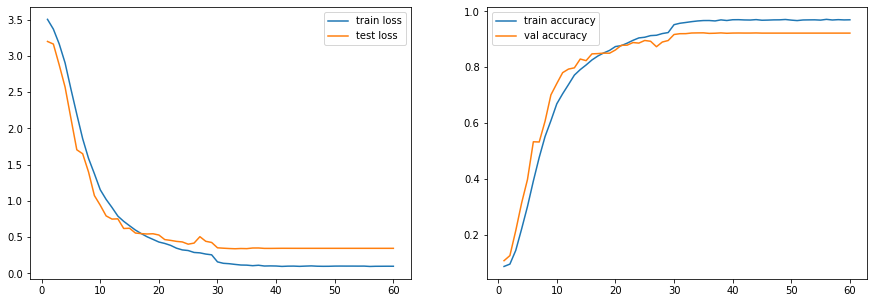

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(np.arange(1,EPOCHES+1), history_train, label='train loss')
ax[0].plot(np.arange(1,EPOCHES+1), history_val, label='test loss')
ax[0].legend()

ax[1].plot(np.arange(1,EPOCHES+1), accuracy_train, label='train accuracy')
ax[1].plot(np.arange(1,EPOCHES+1), accuracy_val, label='val accuracy')
ax[1].legend()

Model stopped learn about 40 epoch with F1 score 82%